## SWAHILI SENTIMENT CLASSIFICASING TRANSFORMERS

About the datasets used to create this tutorial [here](https://zindi.africa/competitions/swahili-news-classification/data)

In [ ]:
# %update pip package & install ktrain

!pip install -U pip
!pip install ktrain


     |████████████████████████████████| 2.1 MB 5.0 MB/s 
  Attempting uninstall: pip
    Found existing installation: pip 21.1.3
    Uninstalling pip-21.1.3:
      Successfully uninstalled pip-21.1.3
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 25.3/25.3 MB 49.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 16.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 KB 60.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 263.7/263.7 KB 30.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.8/468.8 KB 43.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 596.3/596.3 KB 49.6 MB/s eta 

### LIBRARIES

In [ ]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
from nltk import word_tokenize
import string
import re

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# %setting our working director accessible so that to avoid writting long dir path 

os.chdir("/content/drive/MyDrive/Swahili sentiment Analysis using transformers")

### LOAD DATASETS

In [ ]:
# %loading datasets from data dir
df = pd.read_csv("data/Train.csv")

# Total Records
print("Total Records: ", df.shape[0])

# % preview data from top
df.head()

Total Records:  5151


,id,content,category
0,SW0,SERIKALI imesema haitakuwa tayari kuona amani...,Kitaifa
1,SW1,"Mkuu wa Mkoa wa Tabora, Aggrey Mwanri amesiti...",Biashara
2,SW10,SERIKALI imetoa miezi sita kwa taasisi zote z...,Kitaifa
3,SW100,KAMPUNI ya mchezo wa kubahatisha ya M-bet ime...,michezo
4,SW1000,WATANZANIA wamekumbushwa kusherehekea sikukuu...,Kitaifa


In [ ]:
# %Let's check distribution of Labels
df.category.value_counts()

Kitaifa      2000
michezo      1720
Biashara     1360
Kimataifa      54
Burudani       17
Name: category, dtype: int64

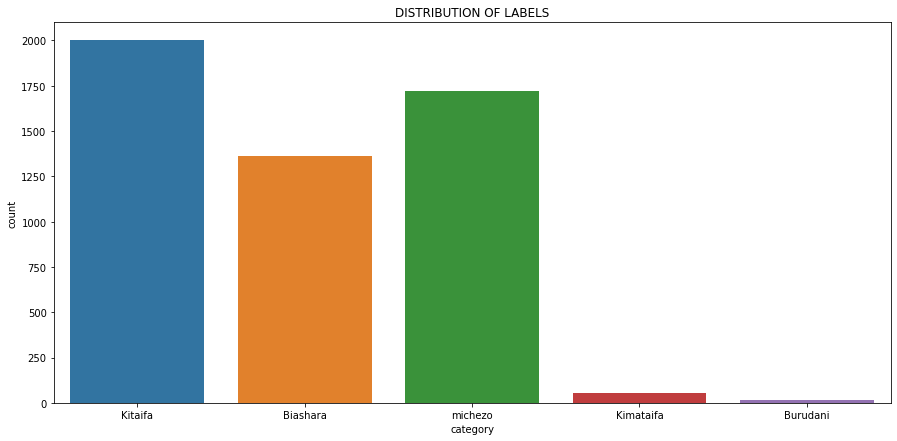

In [ ]:
# %Let's visualize the Label distiributions using seaborn
plt.figure(figsize=(15,7))
sns.countplot(x='category',data=df)
plt.title("DISTRIBUTION OF LABELS")
plt.show()

###### OBSERVATION

- Classes are not well balanced
- Kitaifa text are the Majority, while Burudani text are the Minority

## DATA PREPROCESSING

**Why do we preprocess text?**

Text data contains noise in various forms like punctuation, text in different case, emojis etc.  <br> Text preprocessing is a method to clean the text data and make it ready to feed data to the model.

**Tasks involved**
- Removing punctuation
- Removing digits
- Converting to lower case
- Removing unnecessary white spaces
- Removing emojis
- Removing stopwords
- Tokenization etc


In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# %function to clean text
def clean_text(sentence):
    '''
        function to clean content column, make it ready for transformation and modeling
    '''
    sentence = sentence.lower()                #convert text to lower-case
    sentence = re.sub('â€˜','',sentence)    # remove the text â€˜ which appears to occur flequently
    sentence = re.sub('[‘’“”…,]', '', sentence) # remove punctuation
    sentence = re.sub('[()]', '', sentence)  #remove parentheses
    sentence = re.sub("[^a-zA-Z]"," ",sentence) #remove numbers and keep text/alphabet only
    sentence = word_tokenize(sentence)      # remove repeated characters (tanzaniaaaaaaaa to tanzania)
    
    return ' '.join(sentence)

In [ ]:
# % Applying our clean_text function on contents
df['content'] = df['content'].apply(clean_text)   
df.head()

,id,content,category
0,SW0,serikali imesema haitakuwa tayari kuona amani ...,Kitaifa
1,SW1,mkuu wa mkoa wa tabora aggrey mwanri amesitish...,Biashara
2,SW10,serikali imetoa miezi sita kwa taasisi zote za...,Kitaifa
3,SW100,kampuni ya mchezo wa kubahatisha ya m bet imei...,michezo
4,SW1000,watanzania wamekumbushwa kusherehekea sikukuu ...,Kitaifa


In [ ]:
# remove short words
df['content'] = df['content'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

##  SPLIT DATA INTO TRAINING AND VALDATION SET

In [ ]:
df = df[['category', 'content']] 
SEED = 2020
df_train = df.sample(frac=0.85, random_state=SEED)
df_test = df.drop(df_train.index)
len(df_train), len(df_test)

(4378, 773)

With the Transformer API in ktrain, we can select any Hugging Face transformers model appropriate for our data. Since we are dealing with Swahili, we will use multilingual BERT (which is normally used by ktrain for non-English datasets in the alternative text_classifier API in ktrain).

In [ ]:
import ktrain
from ktrain import text

# %selecting transformer to use
MODEL_NAME = 'bert-base-multilingual-uncased'

# %Common parameters
MAXLEN  = 128 # Only consider the first 120 words of each news content
batch_size = 32 #  the number of training examples utilised in one iteration.
learning_rate = 5e-5 # the amount that the weights are updated during training
epochs = 3 # the number of passes of the entire training dataset the algorithm has completed
t = text.Transformer(MODEL_NAME, maxlen = MAXLEN)
trn = t.preprocess_train(df_train.content.values, df_train.category.values)
val = t.preprocess_test(df_test.content.values, df_test.category.values)
model = t.get_classifier()
learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=batch_size)
learner.fit(learning_rate, epochs)

Downloading:   0%|          | 0.00/625 [00:00<?, ?B/s]

preprocessing train...
language: sw
train sequence lengths:
	mean : 257
	95percentile : 544
	99percentile : 870


Downloading:   0%|          | 0.00/872k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.72M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Is Multi-Label? False
preprocessing test...
language: sw
test sequence lengths:
	mean : 253
	95percentile : 520
	99percentile : 894


Downloading:   0%|          | 0.00/999M [00:00<?, ?B/s]

Epoch 1/3
137/137 [==============================] - 137s 856ms/step - loss: 0.5904 - accuracy: 0.7716 - val_loss: 0.4203 - val_accuracy: 0.8461
Epoch 2/3
137/137 [==============================] - 121s 880ms/step - loss: 0.3878 - accuracy: 0.8563 - val_loss: 0.3650 - val_accuracy: 0.8590
Epoch 3/3
137/137 [==============================] - 121s 878ms/step - loss: 0.3148 - accuracy: 0.8840 - val_loss: 0.3653 - val_accuracy: 0.8435


Now you can see our trained model with the accuracy score of 88.40% of train_set and 84.35 of validation set

## CLASSIFY NEW SWAHILI SENTENCE

In [ ]:
swahili_classifier = ktrain.get_predictor(learner.model, t)

Predict the label of the first sentence in `Train.csv` file <br> <br>
"*SERIKALI imesema haitakuwa tayari kuona amani na utulivu wa nchi inachezewa huku ikisisitiza uwepo wa umoja kati ya wananchi bila kujali tofauti ya imani, kabila au itikadi yoyote.Hayo yalisemwa na Naibu Waziri wa Mambo ya Ndani ya Nchi, Hamad Yussuf Masauni wakati akifungua semina ya siku mbili iliyofanyika jijini Dar es Salaam ikiwahusisha viongozi wa taasisi za Kiislamu, lengo ikiwa ni kuwakumbusha kuhubiri amani katika sehemu zao.Naibu Waziri amesema mwelekeo na malengo ya Serikali ya Awamu ya Tano ni kukuza maendeleo katika sehemu mbalimbali nchini lengo ikiwa kuinua maisha ya wananchi na nchi kwa ujumla.“Serikali hii imejidhatiti kuhakikisha maendeleo yanakuja kwa kasi na maendeleo hayawezi kuja ikiwa amani na utulivu haupo, sisi kama serikali tutahakikisha tunalinda amani iliyopo ili wananchi wapate kufanya shughuli za kiuchumi bila wasiwasi wowote,” amesema Masauni.Akizungumza wakati wa ufunguzi huo, Shehe wa Mkoa wa Dar es Salaam, Alhaji Alhad Mussa Salum aliihakikishia serikali kutokuwepo kwa mifarakano kati ya taasisi mbalimbali kama ilivyokuwepo awali huku akisisitiza kuendelea kwa umoja huo ili jamii ipate kuendelea.“Sisi kama Bakwata tunaihakikishia serikali uwepo wa umoja na ushirikiano baina ya baraza na taasisi zingine na tofauti zetu hazipelekei kukoseana au kuvunjiana heshima kwahiyo tunaomba serikali iamini uwepo wa maelewano mazuri tu kwa maendeleo ya nchi hii,” amesema Shehe Alhad.Semina hiyo ya siku mbili imejumuisha viongozi wa taasisi 100 huku mada ya Nafasi ya Taasisi za Kiislamu katika Kuleta Umoja na Kuishi kwa Amani itajadiliwa*."

In [ ]:
swahili_classifier.predict(clean_text("SERIKALI imesema haitakuwa tayari kuona amani na utulivu wa nchi inachezewa huku ikisisitiza uwepo wa umoja kati ya wananchi bila kujali tofauti ya imani, kabila au itikadi yoyote.Hayo yalisemwa na Naibu Waziri wa Mambo ya Ndani ya Nchi, Hamad Yussuf Masauni wakati akifungua semina ya siku mbili iliyofanyika jijini Dar es Salaam ikiwahusisha viongozi wa taasisi za Kiislamu, lengo ikiwa ni kuwakumbusha kuhubiri amani katika sehemu zao.Naibu Waziri amesema mwelekeo na malengo ya Serikali ya Awamu ya Tano ni kukuza maendeleo katika sehemu mbalimbali nchini lengo ikiwa kuinua maisha ya wananchi na nchi kwa ujumla.“Serikali hii imejidhatiti kuhakikisha maendeleo yanakuja kwa kasi na maendeleo hayawezi kuja ikiwa amani na utulivu haupo, sisi kama serikali tutahakikisha tunalinda amani iliyopo ili wananchi wapate kufanya shughuli za kiuchumi bila wasiwasi wowote,” amesema Masauni.Akizungumza wakati wa ufunguzi huo, Shehe wa Mkoa wa Dar es Salaam, Alhaji Alhad Mussa Salum aliihakikishia serikali kutokuwepo kwa mifarakano kati ya taasisi mbalimbali kama ilivyokuwepo awali huku akisisitiza kuendelea kwa umoja huo ili jamii ipate kuendelea.“Sisi kama Bakwata tunaihakikishia serikali uwepo wa umoja na ushirikiano baina ya baraza na taasisi zingine na tofauti zetu hazipelekei kukoseana au kuvunjiana heshima kwahiyo tunaomba serikali iamini uwepo wa maelewano mazuri tu kwa maendeleo ya nchi hii,” amesema Shehe Alhad.Semina hiyo ya siku mbili imejumuisha viongozi wa taasisi 100 huku mada ya Nafasi ya Taasisi za Kiislamu katika Kuleta Umoja na Kuishi kwa Amani itajadiliwa."))

'Kitaifa'

You can see, has predicted correctly

In [ ]:
swahili_classifier.predict(clean_text("Simba ni timu bora kwa misimu miwili iliyopita katika ligi kuu ya tanzania"))

'michezo'

In [ ]:
swahili_classifier.predict(clean_text("Juma Jux ni moja kati ya wanamziki wenye ubunifu mkubwa katika mavazi kutoka Tanzania "))

'Biashara'

## SAVING OUR SWAHILI SENTIMENT CLASSIFIER MODEL 

In [ ]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


In [ ]:
# save model for later use
swahili_classifier.save('model/swahili_news_classifier')

## LOADING MODEL

In [ ]:
# reload from disk
predictor = ktrain.load_predictor('model/swahili_news_classifier')

In [ ]:
predictor.predict(clean_text("Simba ni timu bora kwa misimu miwili iliyopita katika ligi kuu ya tanzania"))

'michezo'